# Diffusion on Synthetic Manifolds

In this exploration, I will be creating a swiss roll data sampler and then will run diffusion on that synthetic data. The idea here is that diffusion is learning the manifold implicitly and what extent can we show this. If this is the case, can we use a diffusion model in a real setting to create synthetic data to better learn a manifold. Furthermore, is there anyway you could use a learned manifold to try and help the sample complexity of the diffusion model?

## Is Diffusion implicitly learning the manifold of the data?

### ChatGPT created example

First let us create a sampler that will sample data from some swiss roll object,  $x \in \mathbb{R}^d$ living on same $k$-dimensional swiss roll ($k<d$).

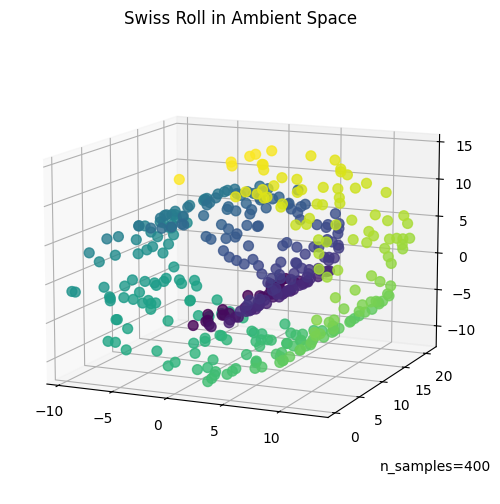

In [2]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
# This class will abstract out all of the data setup. You will be able to just create a synthetic dataset and sample from it
class Sampler():
    # dataset attribute
    X = None
    color = None

    # at init load in swiss roll dataset as default
    def __init__(self, n=400):
        self.create_swiss_roll_dataset(n)

    # Create a swiss roll dataset in $R^3$
    def create_swiss_roll_dataset(self, n, random_state=None, noise=0):
        X, color = make_swiss_roll(n_samples=n, noise=noise, random_state=random_state)
        self.X = X
        self.color = color

    # Sample a random datapoint in the dataset
    def sample(self):
        rand_int = random.randint(0, len(self.X))
        return self.X[rand_int]

    def visualize_swissroll(self):
        # this code is taken directly from the scikit learn documentation: https://scikit-learn.org/stable/auto_examples/manifold/plot_swissroll.html#sphx-glr-auto-examples-manifold-plot-swissroll-py
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")
        fig.add_axes(ax)
        ax.scatter(
            self.X[:, 0], self.X[:, 1], self.X[:, 2], c=self.color, s=50, alpha=0.8
        )
        ax.set_title("Swiss Roll in Ambient Space")
        ax.view_init(azim=-66, elev=12)
        _ = ax.text2D(0.8, 0.05, s=f"n_samples={len(self.X)}", transform=ax.transAxes)

sampler = Sampler()
sampler.visualize_swissroll()

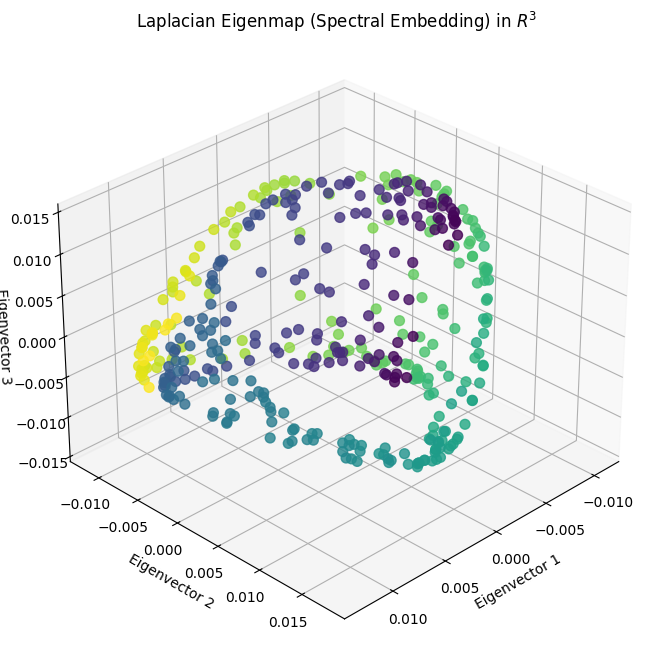

In [3]:
from sklearn.manifold import SpectralEmbedding

# 1. Perform Laplacian Eigenmaps (Spectral Embedding)
# We use 'nearest_neighbors' affinity to construct the graph Laplacian
embedding = SpectralEmbedding(n_components=3, affinity='nearest_neighbors', random_state=42)
X_transformed = embedding.fit_transform(sampler.X)

# 2. Visualize the Results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X_transformed[:, 0], 
    X_transformed[:, 1], 
    X_transformed[:, 2], 
    c=sampler.color,  # Use original colors to track the manifold structure
    s=50, 
    alpha=0.8,
    cmap='viridis'
)

ax.set_title("Laplacian Eigenmap (Spectral Embedding) in $R^3$")
ax.set_xlabel("Eigenvector 1")
ax.set_ylabel("Eigenvector 2")
ax.set_zlabel("Eigenvector 3")

# Adjust view for better perspective of the manifold structure
ax.view_init(azim=45, elev=30)

plt.show()

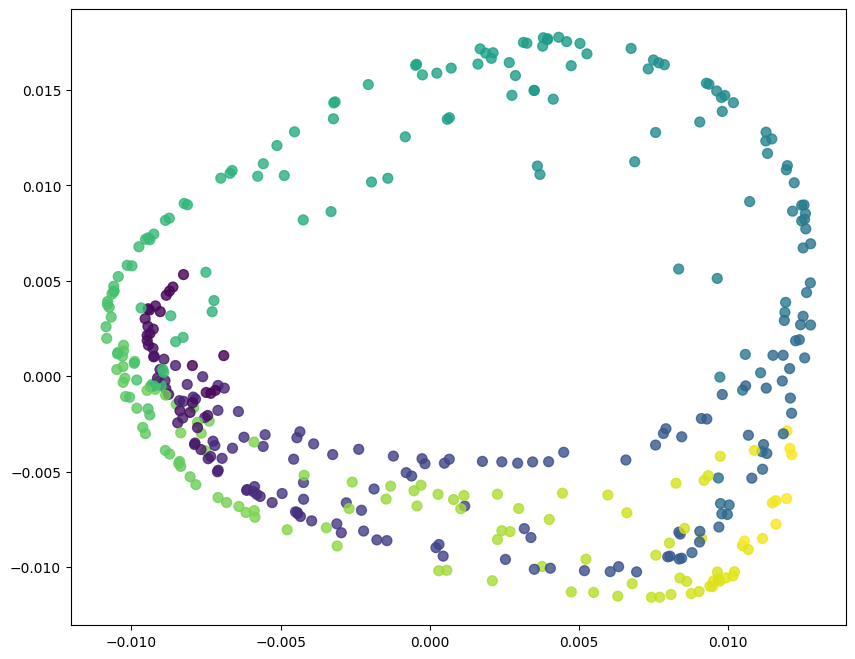

In [5]:
# 2. Visualize the Results in 3D
fig = plt.figure(figsize=(10, 8))

plt.scatter(
    X_transformed[:, 0], 
    X_transformed[:, 1], 
    c=sampler.color,  # Use original colors to track the manifold structure
    s=50, 
    alpha=0.8,
    cmap='viridis'
)

ax.set_title("Laplacian Eigenmap (Spectral Embedding) in $R^3$")
ax.set_xlabel("Eigenvector 1")
ax.set_ylabel("Eigenvector 2")

# Adjust view for better perspective of the manifold structure
ax.view_init(azim=45, elev=30)

plt.show()

Next is to define a noise scheduler. For simplicity I will define a linear schedule with $\sigma \in [0.01, 100]$

In [38]:
import torch
import numpy as np
import random

class noise_scheduler:
    """Simple linear noise scheduler for diffusion-style experiments.

    Given a timestep t, this class returns a Gaussian noise level (standard
    deviation) from a linear schedule and can directly add noise to a data point.
    """

    def __init__(self, num_steps: int = 10000,
                 min_noise: float = 0.01,
                 max_noise: float = 100,
                 device: str = "cpu"):
        """Create a linear noise schedule.

        Args:
            num_steps: How many timesteps in the schedule.
            min_noise: Smallest noise level (at t = 0).
            max_noise: Largest noise level (at t = num_steps - 1).
            device: Torch device ("cpu" or "cuda").
        """
        self.num_steps = num_steps
        self.device = device

        # Linearly spaced noise levels from min_noise to max_noise.
        # This will be our "schedule" of standard deviations.
        self.schedule = torch.linspace(min_noise, max_noise,
                                       steps=num_steps,
                                       device=device)

    def get_sigma(self, t: int) -> torch.Tensor:
        """Return the noise standard deviation for timestep t.

        Args:
            t: Integer timestep index in [0, num_steps - 1].
        """
        # Clamp t just in case it goes slightly out of range.
        t = max(0, min(int(t), self.num_steps - 1))
        return self.schedule[t]

    def gaussian_noise(self, x, t: int = None):
        """Add Gaussian noise to a single data point.

        Args:
            x: Data point. Can be a NumPy array or a torch tensor of shape
               (..., d). For your swiss roll this will be shape (3,) or (batch, 3).
            t: Optional timestep index. If None, a random t is sampled
               uniformly from [0, num_steps - 1].

        Returns:
            x_noisy: Noised version of x.
            noise: The actual Gaussian noise that was added.
            sigma: The noise standard deviation used.
            t: The timestep index that was used.
        """
        # If x is a NumPy array, convert it to a torch tensor.
        if not torch.is_tensor(x):
            x = torch.from_numpy(np.asarray(x)).float()

        # If no timestep is provided, pick one at random.
        if t is None:
            t = random.randint(0, self.num_steps - 1)

        # Get noise scale for this timestep.
        sigma = self.get_sigma(t)

        # Sample standard normal noise with the same shape as x,
        # then scale it by sigma.
        noise = torch.randn_like(x) * sigma

        # Add noise to the original data.
        x_noisy = x + noise

        return x_noisy, noise, sigma

Next is to create the model to predit the noise

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNoisePredictor(nn.Module):
    """
    Very simple MLP to predict Gaussian noise ε from a noised point x_t and timestep t.

    - Input:  x_t (noisy data), shape (3,) or (batch_size, 3)
             t   (timestep),    scalar int or tensor of shape (batch_size,)
    - Output: predicted noise ε_hat, same shape as x_t
    """

    def __init__(self, num_steps: int, input_dim: int = 3, hidden_dim: int = 128):
        super().__init__()

        # We need num_steps so we can normalize t to [0, 1]
        self.num_steps = num_steps

        # Input to the network is x_t (dim=3) plus time scalar (dim=1) -> 4 dims
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)  # output: predicted noise (same dim as x)

        # Non-linearity
        self.act = nn.SiLU()  # you can also use nn.ReLU() if you want it even simpler

    def forward(self, x: torch.Tensor, t):
        """
        Args:
            x: Noisy input point(s). Shape (3,) or (batch_size, 3).
            t: Timestep(s). Can be:
               - Python int
               - 0-D tensor
               - 1-D tensor of shape (batch_size,)
               - 2-D tensor of shape (batch_size, 1)

        Returns:
            eps_pred: Predicted noise with same shape as x.
        """

        # Ensure x has a batch dimension: (3,) -> (1, 3)
        if x.dim() == 1:
            x = x.unsqueeze(0)  # (1, 3)

        # Move x to some device
        device = x.device

        # Convert t to a tensor if it's not one already
        if not torch.is_tensor(t):
            t = torch.tensor(t, device=device)

        t = t.to(device).float()

        # Make t shape (batch_size, 1)
        if t.dim() == 0:
            # same t for the whole batch
            t = t.repeat(x.size(0))  # (batch_size,)
        if t.dim() == 1:
            t = t.unsqueeze(-1)  # (batch_size, 1)

        # Normalize t to [0, 1] for stability:
        # if num_steps = 10000, t_norm = t / 9999
        t_norm = t / (self.num_steps - 1)

        # Concatenate x_t and t along the feature dimension
        # x:      (batch_size, 3)
        # t_norm: (batch_size, 1)
        # -> x_input: (batch_size, 4)
        x_input = torch.cat([x, t_norm], dim=-1)

        # Simple 3-layer MLP
        h = self.act(self.fc1(x_input))
        h = self.act(self.fc2(h))
        eps_pred = self.fc3(h)  # (batch_size, 3)

        # If the original input was a single point (3,), return (3,) as well
        if eps_pred.size(0) == 1:
            return eps_pred.squeeze(0)

        return eps_pred

In [35]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


class SwissRollDDPM:
    """
    Simple DDPM pipeline for a 3D swiss roll dataset.

    - Uses a beta schedule (linear) as in the original DDPM paper.
    - Trains a noise-prediction model ε_θ(x_t, t).
    - Samples new points by running the reverse diffusion process.
    """

    def __init__(
        self,
        sampler,
        num_steps: int = 1000,
        beta_start: float = 1e-4,
        beta_end: float = 0.02,
        hidden_dim: int = 128,
        lr: float = 1e-3,
        device: str | None = None,
    ):
        """
        Args:
            sampler: Your Sampler() instance that holds the swiss roll data.
            num_steps: Number of diffusion timesteps T.
            beta_start, beta_end: Linear beta schedule range.
            hidden_dim: Hidden dimension for SimpleNoisePredictor.
            lr: Learning rate for Adam.
            device: "cpu" or "cuda". If None, auto-detect.
        """
        self.sampler = sampler
        self.T = num_steps

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        # --------------------------
        # DDPM noise schedule setup
        # --------------------------
        # Linear betas from beta_start to beta_end
        self.betas = torch.linspace(beta_start, beta_end, self.T, device=self.device)  # (T,)
        self.alphas = 1.0 - self.betas                                                 # (T,)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)                            # (T,)

        # --------------------------
        # Model & optimizer
        # --------------------------
        # Simple MLP that predicts ε given x_t and t
        self.model = SimpleNoisePredictor(
            num_steps=self.T, input_dim=3, hidden_dim=hidden_dim
        ).to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    # --------------------------
    # Helper: sample a clean batch x_0 from swiss roll
    # --------------------------
    def _sample_clean_batch(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of clean points x_0 from the swiss roll.

        Uses sampler.X directly for speed and to avoid Python loops.
        Returns: x0 of shape (batch_size, 3) as a float32 tensor on self.device.
        """
        # sampler.X is a NumPy array of shape (N, 3)
        N = self.sampler.X.shape[0]
        idx = np.random.randint(0, N, size=batch_size)
        x0_np = self.sampler.X[idx]  # (batch_size, 3)
        x0 = torch.from_numpy(x0_np).float().to(self.device)
        return x0

    # --------------------------
    # Forward diffusion: q(x_t | x_0)
    # --------------------------
    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, noise: torch.Tensor | None = None):
        """
        Sample from q(x_t | x_0) using the closed-form DDPM formula:

            x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * ε,

        where ε ~ N(0, I).

        Args:
            x0: Clean data, shape (batch_size, 3).
            t:  Timesteps, shape (batch_size,) integer tensor in [0, T-1].
            noise: Optional pre-sampled noise (same shape as x0).

        Returns:
            x_t, noise
        """
        if noise is None:
            noise = torch.randn_like(x0)

        # alpha_bar_t: shape (batch_size,)
        alpha_bar_t = self.alpha_bars[t]  # index per example
        alpha_bar_t = alpha_bar_t.unsqueeze(-1)  # (batch_size, 1) for broadcasting

        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1.0 - alpha_bar_t) * noise
        return x_t, noise

    # --------------------------
    # Single training step
    # --------------------------
    def training_step(self, batch_size: int) -> float:
        """
        Perform one gradient step on a random batch and random timesteps.

        Loss is E[ ||ε_θ(x_t, t) - ε||^2 ] as in DDPM.
        """
        self.model.train()

        # 1. Sample clean data x_0
        x0 = self._sample_clean_batch(batch_size)  # (B, 3)

        # 2. Sample random timesteps t ~ Uniform({0,...,T-1})
        t = torch.randint(0, self.T, (batch_size,), device=self.device).long()

        # 3. Sample noise ε ~ N(0, I) and get x_t
        noise = torch.randn_like(x0)
        x_t, _ = self.q_sample(x0, t, noise=noise)

        # 4. Predict noise with the model
        eps_pred = self.model(x_t, t)  # (B, 3)

        # 5. Compute MSE loss between true and predicted noise
        loss = F.mse_loss(eps_pred, noise)

        # 6. Backprop and optimizer step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    # --------------------------
    # Full training loop
    # --------------------------
    def train(self, num_steps: int = 10_000, batch_size: int = 128, log_every: int = 500):
        """
        Train the diffusion model.

        Args:
            num_steps: Number of gradient updates.
            batch_size: Batch size.
            log_every: Print loss every this many steps.
        """
        for step in range(1, num_steps + 1):
            loss = self.training_step(batch_size)

            if step % log_every == 0 or step == 1:
                print(f"[step {step}/{num_steps}] loss = {loss:.6f}")

    # --------------------------
    # Reverse process: p_θ(x_{t-1} | x_t)
    # --------------------------
    def p_sample(self, x_t: torch.Tensor, t: int) -> torch.Tensor:
        """
        Sample x_{t-1} given x_t using the DDPM update:

          μ_θ(x_t, t) = 1/sqrt(α_t) * ( x_t - β_t / sqrt(1 - ᾱ_t) * ε_θ(x_t, t) )
          x_{t-1} ~ N( μ_θ(x_t, t), β_t I )

        For t = 0, we just return the mean (no noise term).
        """
        # Create a batch of timesteps filled with the scalar t
        batch_size = x_t.shape[0]
        t_batch = torch.full((batch_size,), t, device=self.device, dtype=torch.long)

        # Predict noise ε_θ(x_t, t)
        eps_theta = self.model(x_t, t_batch)  # (B, 3)

        beta_t = self.betas[t]        # scalar tensor
        alpha_t = self.alphas[t]      # scalar tensor
        alpha_bar_t = self.alpha_bars[t]  # scalar tensor

        # Compute the mean of p_θ(x_{t-1} | x_t)
        # μ_θ(x_t, t) = 1/sqrt(α_t) * ( x_t - β_t / sqrt(1 - ᾱ_t) * ε_θ(x_t, t) )
        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = beta_t / torch.sqrt(1.0 - alpha_bar_t)

        mean = coef1 * (x_t - coef2 * eps_theta)  # (B, 3)

        if t == 0:
            # No noise at the final step
            return mean

        # Add Gaussian noise with variance β_t
        noise = torch.randn_like(x_t)
        sigma_t = torch.sqrt(beta_t)
        x_prev = mean + sigma_t * noise
        return x_prev

    # --------------------------
    # Generate new samples x_0
    # --------------------------
    def sample(self, num_samples: int = 1000) -> np.ndarray:
        """
        Run the full reverse diffusion chain starting from x_T ~ N(0, I).

        Returns:
            samples: NumPy array of shape (num_samples, 3) on CPU.
        """
        self.model.eval()

        # Start from pure Gaussian noise at timestep T-1
        x_t = torch.randn(num_samples, 3, device=self.device)

        # Iterate backwards from T-1 to 0
        for t in reversed(range(self.T)):
            x_t = self.p_sample(x_t, t)

        # x_t is now an approximation of x_0
        x_0 = x_t.detach().cpu().numpy()
        return x_0

    # --------------------------
    # Visualization helper
    # --------------------------
    def visualize_generated(self, num_samples: int = 2000):
        """
        Generate samples and visualize them as a 3D scatter plot.
        """
        samples = self.sample(num_samples=num_samples)  # (N, 3)

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")
        fig.add_axes(ax)

        ax.scatter(
            samples[:, 0],
            samples[:, 1],
            samples[:, 2],
            s=5,
            alpha=0.8,
        )

        ax.set_title("Generated Samples from DDPM (Swiss Roll)")
        ax.view_init(azim=-66, elev=12)
        plt.show()


[step 1/10000] loss = 1.048989
[step 500/10000] loss = 0.612425
[step 1000/10000] loss = 0.582912
[step 1500/10000] loss = 0.521750
[step 2000/10000] loss = 0.524558
[step 2500/10000] loss = 0.550501
[step 3000/10000] loss = 0.517019
[step 3500/10000] loss = 0.650559
[step 4000/10000] loss = 0.622248
[step 4500/10000] loss = 0.457383
[step 5000/10000] loss = 0.508280
[step 5500/10000] loss = 0.632057
[step 6000/10000] loss = 0.551222
[step 6500/10000] loss = 0.555078
[step 7000/10000] loss = 0.593725
[step 7500/10000] loss = 0.608628
[step 8000/10000] loss = 0.492633
[step 8500/10000] loss = 0.425227
[step 9000/10000] loss = 0.597624
[step 9500/10000] loss = 0.513351
[step 10000/10000] loss = 0.424139


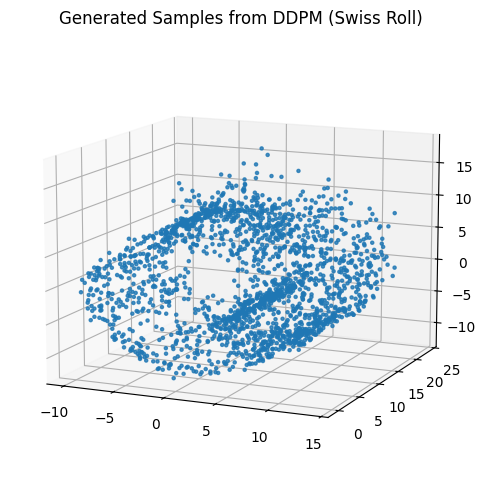

In [43]:
# 1. Create the swiss roll data
sampler = Sampler(n=400)  # from your code

# 2. Set up the diffusion model
ddpm = SwissRollDDPM(
    sampler=sampler,
    num_steps=1000,
    beta_start=1e-4,
    beta_end=0.02,
    hidden_dim=128,
    lr=1e-3,
)

# 3. Train
ddpm.train(num_steps=10_000, batch_size=128, log_every=500)

# 4. Visualize generated samples
ddpm.visualize_generated(num_samples=2000)


### Smalldiffusion example

See reference - https://github.com/yuanchenyang/smalldiffusion/blob/main/examples/toyexample.ipynb

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from smalldiffusion import (
    TimeInputMLP, ScheduleLogLinear, training_loop, samples,
    DatasaurusDozen, Swissroll
)

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

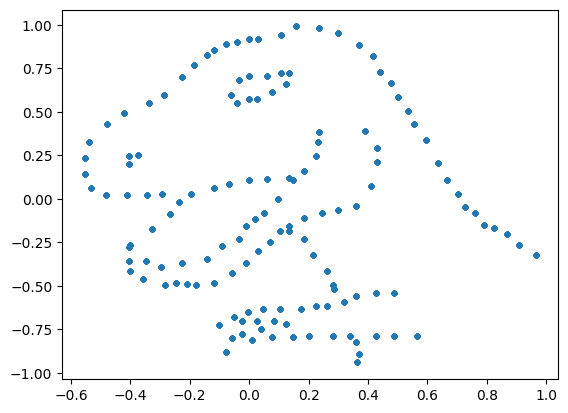

In [21]:
# Try replacing dataset with 'dino', 'bullseye', 'h_lines', 'x_shape', etc. 
dataset = DatasaurusDozen(csv_file='./data/DatasaurusDozen.tsv', dataset='dino')
# Or use the SwissRoll dataset
# dataset = Swissroll(np.pi/2, 5*np.pi, 100)
loader = DataLoader(dataset, batch_size=2130)
plot_batch(next(iter(loader)))

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rd/mp__2p510kndbjc_f7sc4jz00000gn/T/ipykernel_88359/445830193.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_t$')


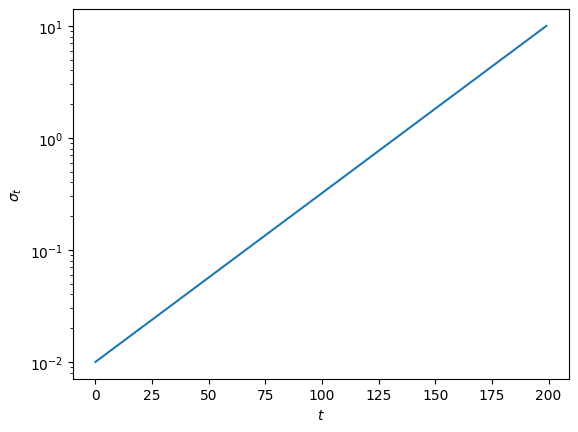

In [22]:
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/var/folders/rd/mp__2p510kndbjc_f7sc4jz00000gn/T/ipykernel_88359/1963255254.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
/var/folders/rd/mp__2p510kndbjc_f7sc4jz00000gn/T/ipykernel_88359/1963255254.py:4: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')


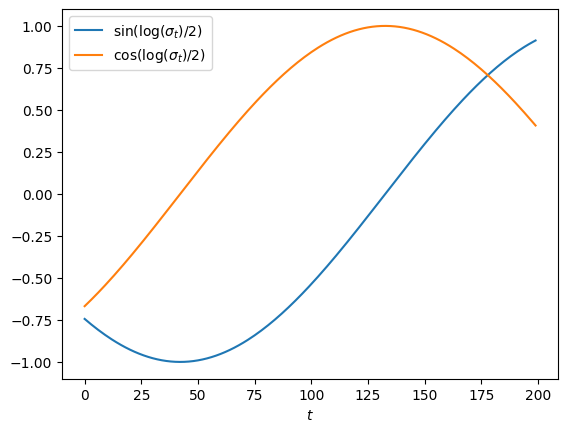

In [23]:
from smalldiffusion.model import get_sigma_embeds
sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [24]:
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)

TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [25]:
trainer = training_loop(loader, model, schedule, epochs=15000, lr=1e-3)
losses = [ns.loss.item() for ns in trainer]

100%|██████████| 15000/15000 [01:07<00:00, 221.61it/s]


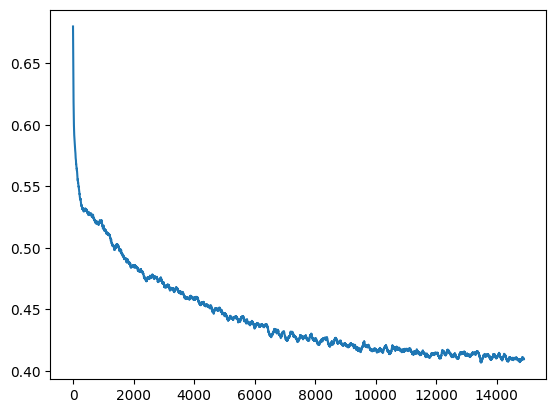

In [26]:
plt.plot(moving_average(losses, 100))
plt.show()

DDPM Sampling

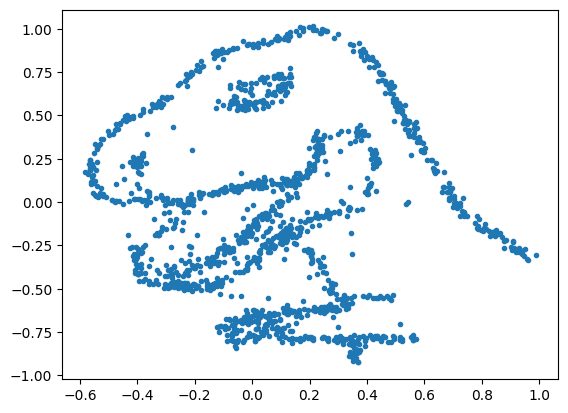

In [27]:
# For DDPM sampling, change to gam=1, mu=0.5
# For DDIM sampling, change to gam=1, mu=0
*xts, x0 = samples(model, schedule.sample_sigmas(20), batchsize=1500, gam=1, mu=0.5)
plot_batch(x0)

DDIM Sampling

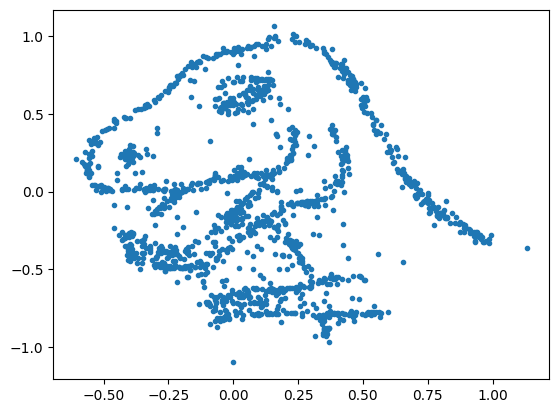

In [28]:
*xts, x0 = samples(model, schedule.sample_sigmas(20), batchsize=1500, gam=1, mu=0)
plot_batch(x0)